<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_ML_NPASS/blob/main/Part7(a)_XAI_for_QDA_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Here, we will use further the explanble-AI (XAI) approch using SHAP module for the selected models

In [ ]:
pip install shap

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Loading the saved QDA + ROS model

import pickle

with open("QDA_ROS_model.pkl", "rb") as f: #change the model name accordingly
    model = pickle.load(f)

# Loading Test set

import pandas as pd

# Load complete test set #change the test set name accordingly
test_df = pd.read_csv("QDA_ROS_Testset.csv")

# Separate X (features) and y (labels)
X_test = test_df.drop("BioactivityClass", axis=1)
y_test = test_df["BioactivityClass"]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (493, 20)
y_test shape: (493,)


#If your saved model is tree-based (RandomForest, XGBoost, LightGBM, CatBoost
use TreeExplainer (fast, accurate)

#If it’s not tree-based (SVM, Logistic Regression, MLP, QDA, etc.):
use KernelExplainer (model-agnostic but slower)

Background size: 100, Samples to explain: 288, Feature count: 20


  0%|          | 0/288 [00:00<?, ?it/s]

KernelExplainer finished in 1613.5 s
raw shap_values type: <class 'numpy.ndarray'>
Extracted class 1 from 3D numpy array.
shap_values_to_use.shape: (288, 20)
X_explain.shape: (288, 20)
Saved SHAP CSV -> qda_shap_values_class1.csv
Saved SHAP NPZ -> qda_shap_values_class1.npz
Saved predicted labels -> qda_explained_preds.csv
Saved class-1 probabilities -> qda_explained_prob_class1.csv
Saved feature importance -> qda_shap_feature_importance_mean_abs.csv


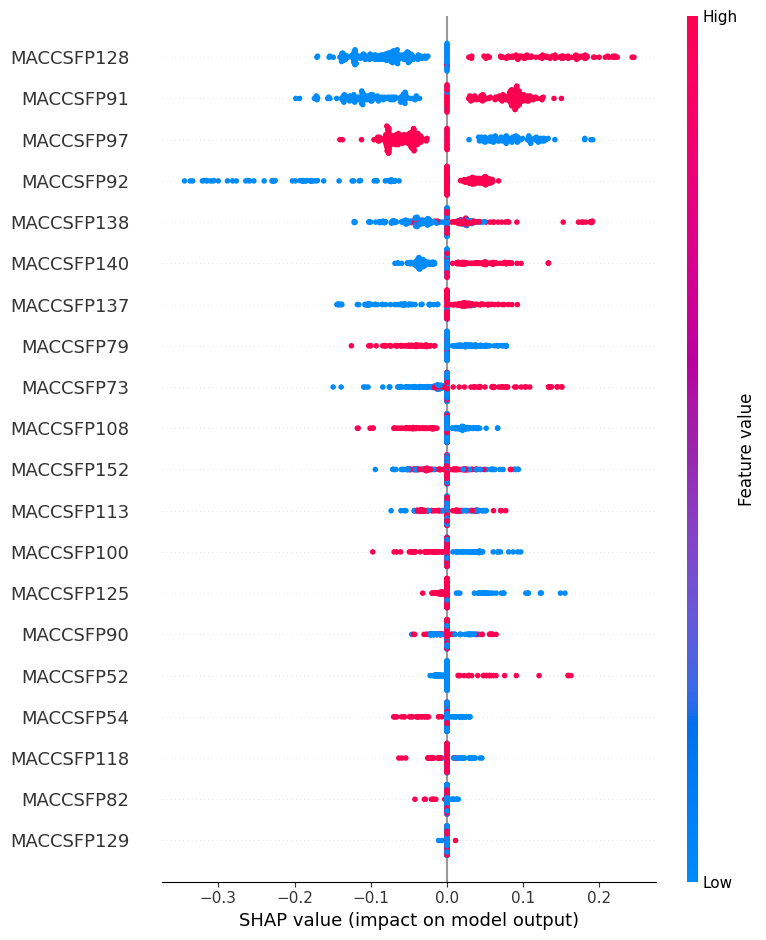

Saved beeswarm -> QDA_ROS_SHAP_summary_beeswarm.png
Saved long-format SHAP -> qda_shap_values_long_format.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Triggered download for key files (Colab).

--- Diagnostics: SHAP head (first 5 rows) ---
   MACCSFP52  MACCSFP54  MACCSFP73  MACCSFP79  MACCSFP82  MACCSFP90  \
0  -0.015063        0.0   0.000000   0.000000        0.0  -0.020897   
1   0.000000        0.0   0.000000   0.023049        0.0   0.030115   
2  -0.014545        0.0   0.000000   0.000000        0.0  -0.021222   
3  -0.004796        0.0   0.000000   0.000000        0.0  -0.008739   
4  -0.009835        0.0  -0.011902   0.000000        0.0  -0.013966   

   MACCSFP91  MACCSFP92  MACCSFP97  MACCSFP100  MACCSFP108  MACCSFP113  \
0   0.092046   0.000000  -0.079556    0.046764    0.000000   -0.034741   
1  -0.122996  -0.071002   0.118896    0.000000    0.019813    0.016588   
2   0.092275   0.000000  -0.077206    0.043613    0.000000   -0.032109   
3  -0.099607   0.000000  -0.072414    0.000000    0.000000   -0.037482   
4  -0.121744   0.000000  -0.062962    0.000000    0.000000   -0.028490   

   MACCSFP118  MACCSFP125  MACCSFP128  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

# ----- USER: adjust these if your variables have different names -----
model_var = 'QDA_ROS_model'      # your trained QDA model variable name
X_test_var = 'QDA_ROS_Testset'    # your test DataFrame variable name
background_size = 100    # background sample size for KernelExplainer (reduce to speed up)
max_samples = 300        # max number of samples to explain (reduce to speed up)
random_state = 42
# --------------------------------------------------------------------

# 1) Clean X_test (drop NaNs) and pick subset to explain
X_test_cleaned = X_test.dropna()
n_available = len(X_test_cleaned)
if n_available == 0:
    raise RuntimeError("No rows remain after X_test.dropna(). Check your X_test DataFrame.")

n_background = min(background_size, n_available)
background = X_test_cleaned.sample(n_background, random_state=random_state)
n_explain = min(max_samples, n_available)
X_explain = X_test_cleaned.iloc[:n_explain].copy()

print(f"Background size: {n_background}, Samples to explain: {n_explain}, Feature count: {X_explain.shape[1]}")

# 2) Build KernelExplainer using model.predict_proba (QDA)
# KernelExplainer expects numpy arrays as inputs when used with a callable
explainer = shap.KernelExplainer(model.predict_proba, background.values)

# 3) Compute SHAP values (this returns array/list shaped (n_samples, n_features, n_classes) for predict_proba)
start = time.time()
shap_values = explainer.shap_values(X_explain.values)   # may be slow; progress bar not built-in
elapsed = time.time() - start
print(f"KernelExplainer finished in {elapsed:.1f} s")

# 4) Inspect returned shape and pick class 1
# Typical shape for binary classification: a list [shap_for_class0, shap_for_class1]
# OR a single array shaped (n_samples, n_features, n_classes) depending on shap version
print("raw shap_values type:", type(shap_values))

# Normalize the output into shap_values_to_use: shape (n_samples, n_features)
if isinstance(shap_values, list) and len(shap_values) >= 2:
    # shap_values is list-like [class0, class1]; each element shape (n_samples, n_features)
    shap_values_to_use = np.asarray(shap_values[1])   # choose positive class (class 1)
    print("Using shap_values[1] (positive class).")
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # shape (n_samples, n_features, n_classes)
    shap_values_to_use = shap_values[:, :, 1]
    print("Extracted class 1 from 3D numpy array.")
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    # shape already (n_samples, n_features)
    shap_values_to_use = shap_values
    print("SHAP returned 2D array; using it directly.")
else:
    # fallback: try to convert to numpy and select last axis class 1 if possible
    try:
        arr = np.asarray(shap_values)
        if arr.ndim == 3:
            shap_values_to_use = arr[:, :, 1]
            print("Converted to numpy and extracted class 1.")
        elif arr.ndim == 2:
            shap_values_to_use = arr
            print("Converted to numpy 2D and using it.")
        else:
            raise ValueError("Unexpected shap_values shape: " + str(arr.shape))
    except Exception as e:
        raise RuntimeError("Cannot interpret shap_values object. Print its type/shape and inspect.") from e

print("shap_values_to_use.shape:", shap_values_to_use.shape)
print("X_explain.shape:", X_explain.shape)
if shap_values_to_use.shape[0] != X_explain.shape[0] or shap_values_to_use.shape[1] != X_explain.shape[1]:
    raise RuntimeError("Shape mismatch: SHAP values and X_explain must have same (samples,features). "
                       f"shap: {shap_values_to_use.shape}, X_explain: {X_explain.shape}")

# 5) Create DataFrame and save SHAP values
shap_df = pd.DataFrame(shap_values_to_use, index=X_explain.index, columns=X_explain.columns)
csv_name = "qda_shap_values_class1.csv"
npz_name = "qda_shap_values_class1.npz"
shap_df.to_csv(csv_name, index=True)
np.savez_compressed(npz_name, shap=shap_values_to_use, index=np.array(X_explain.index), columns=np.array(X_explain.columns))
print(f"Saved SHAP CSV -> {csv_name}")
print(f"Saved SHAP NPZ -> {npz_name}")

# 6) Optional: save predicted labels/probabilities for explained samples
try:
    preds = model.predict(X_explain)
    pd.Series(preds, index=X_explain.index, name="pred").to_csv("qda_explained_preds.csv")
    print("Saved predicted labels -> qda_explained_preds.csv")
except Exception:
    print("model.predict() failed or not available; skipping predicted labels.")

try:
    probs = model.predict_proba(X_explain)
    if probs is not None and probs.shape[1] >= 2:
        pd.Series(probs[:,1], index=X_explain.index, name="prob_class1").to_csv("qda_explained_prob_class1.csv")
        print("Saved class-1 probabilities -> qda_explained_prob_class1.csv")
except Exception:
    print("model.predict_proba() failed or not available; skipping probabilities.")

# 7) Per-feature mean(|SHAP|) importance and save
feat_importance = pd.DataFrame({
    "feature": X_explain.columns,
    "mean_abs_shap": np.abs(shap_df).mean(axis=0).values,
    "mean_shap": shap_df.mean(axis=0).values
}).sort_values("mean_abs_shap", ascending=False)
feat_importance.to_csv("qda_shap_feature_importance_mean_abs.csv", index=False)
print("Saved feature importance -> qda_shap_feature_importance_mean_abs.csv")

# 8) Beeswarm plot (summary)
plt.figure(figsize=(8,10))
shap.summary_plot(shap_values_to_use, X_explain, feature_names=X_explain.columns, show=False)
plt.tight_layout()
plt.savefig("QDA_ROS_SHAP_summary_beeswarm.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved beeswarm -> QDA_ROS_SHAP_summary_beeswarm.png")

# 9) Long format (sample, feature, shap_value)
long_df = shap_df.reset_index().melt(id_vars=X_explain.index.name or "index", var_name="feature", value_name="shap_value")
long_csv = "qda_shap_values_long_format.csv"
long_df.to_csv(long_csv, index=False)
print("Saved long-format SHAP ->", long_csv)

# 10) Attempt to trigger Colab downloads (harmless if not in Colab)
try:
    from google.colab import files
    files.download(csv_name)
    files.download(npz_name)
    files.download("qda_shap_feature_importance_mean_abs.csv")
    files.download("QDA_ROS_SHAP_summary_beeswarm.png")
    print("Triggered download for key files (Colab).")
except Exception:
    print("Not in Colab or browser download failed — files saved in working directory.")

# 11) Diagnostic prints: head + top features
print("\n--- Diagnostics: SHAP head (first 5 rows) ---")
print(shap_df.head())
print("\nTop features by mean(|SHAP|):")
print(feat_importance.head(20))

# end of cell


In [ ]:
!zip -r XAI_QDA_ROS_SHAP * .csv * .png

	zip warning: name not matched: .csv
	zip warning: name not matched: .png
  adding: qda_explained_preds.csv (deflated 63%)
  adding: qda_explained_prob_class1.csv (deflated 70%)
  adding: QDA_ROS_model.pkl (deflated 86%)
  adding: QDA_ROS_SHAP_summary_beeswarm.png (deflated 11%)
  adding: QDA_ROS_Testset.csv (deflated 94%)
  adding: qda_shap_feature_importance_mean_abs.csv (deflated 53%)
  adding: qda_shap_values_class1.csv (deflated 59%)
  adding: qda_shap_values_class1.npz (deflated 0%)
  adding: qda_shap_values_long_format.csv (deflated 70%)
  adding: sample_data/ (stored 0%)
  adding: sample_data/README.md (deflated 39%)
  adding: sample_data/anscombe.json (deflated 83%)
  adding: sample_data/california_housing_test.csv (deflated 76%)
  adding: sample_data/mnist_test.csv (deflated 88%)
  adding: sample_data/mnist_train_small.csv (deflated 88%)
  adding: sample_data/california_housing_train.csv (deflated 79%)
